<a href="https://colab.research.google.com/github/sairagillani18k/NLP/blob/main/Sentiment_analysis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentiment Analysis**  is a natural language processing (NLP) technique used to determine whether data is positive, negative or neutral.

**BERT** Bidirectional Encoder Representations from Transformers is a transformer-based machine learning technique for natural language processing.
It is designed to help computers understand the meaning of ambiguous language in text by using surrounding text to establish context.

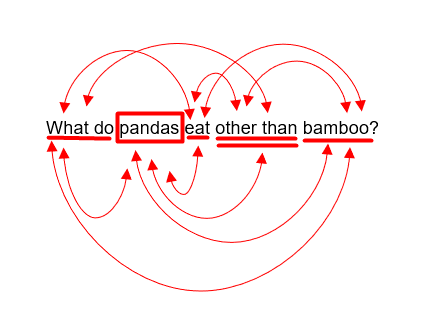

**Import Tensor flow**

In [76]:
import tensorflow as tf

**No of GPUs available**

In [77]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: " , num_gpus_available)
assert num_gpus_available >0

Num GPUs Available:  1


**Install Transformers**

In [ ]:
!pip install transformers

**Import libraries**

In [79]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np

**To getrid of stop words**

In [80]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Lets do Sentiment Analysis on the reviews about Mobile Electronics**

In [81]:
import tensorflow_datasets as tfds
ds = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00' , split = 'train' , shuffle_files = True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

<_OptionsDataset element_spec={'data': {'customer_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'helpful_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'marketplace': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_category': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_parent': TensorSpec(shape=(), dtype=tf.string, name=None), 'product_title': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_body': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_date': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_headline': TensorSpec(shape=(), dtype=tf.string, name=None), 'review_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'star_rating': TensorSpec(shape=(), dtype=tf.int32, name=None), 'total_votes': TensorSpec(shape=(), dtype=tf.int32, name=None), 'verified_purchase': TensorSpec(shape=(), dtype=tf.int64, name=None), 'vine': TensorSpec(shape=(), dtype=

In [85]:
df = tfds.as_dataframe(ds)

In [86]:
df.head(3)

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'20980074',0,b'US',b'Mobile_Electronics',b'B00D1847NE',b'274617424',b'Teenage Mutant Ninja Turtles Boombox CD Play...,b'Does not work',b'2015-01-09',b'One Star',b'R1OVS0D6SEXPW7',1,0,0,1
1,b'779273',0,b'US',b'Mobile_Electronics',b'B00KMO6DYG',b'397452138',b'4 Gauge Amp Kit Amplifier Install Wiring Com...,b'This is a great wiring kit i used it to set ...,b'2015-08-06',b'Great kit',b'R9VSD0ET8FERB',4,0,0,1
2,b'15410531',0,b'US',b'Mobile_Electronics',b'B000GWLL0K',b'948304826',b'Travel Wall Charger fits Creative Zen Vision...,b'It works great so much faster than USB charg...,b'2007-03-15',b'A/C Charger for Creative Zen Vision M',b'R3ISXCZHWLJLBH',5,0,0,1


**Lets do some preprocessing**

We will only be using reviews and star rating columns. 
Make a new column by the name of Sentiments. If the rating in the 'star_rating' column is greater than equal to 3, consider the reviews as **Positive** and assign them the label of "1" else consider them to be **Negative** and assign them "0"


In [83]:
df['Sentiment'] = df["data/star_rating"].apply(lambda score: "positive" if score >=3 else "negative")
df['Sentiment'] = df['Sentiment'].map({'positive':1 , 'negative': 0})
df['short_review']= df['data/review_body'].str.decode("utf-8")
df= df[["short_review", "Sentiment"]]

**Now the data has only 2 columns**

In [ ]:
df.head()

**Reducing the data size for fast training**

In [ ]:
n= 54975
df.drop(df.tail(n).index, inplace = True)

**Convert the reviews and labels into lists**

In [19]:
reviews = df['short_review'].values.tolist()
labels = df['Sentiment'].tolist()

**Lets split the data into training and testing sets**

In [21]:
from sklearn.model_selection import train_test_split
training_sentences , validation_sentences, training_labels, validation_labels= train_test_split(reviews , labels, test_size = 0.2)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
tokenizer([training_sentences[0]], truncation = True , padding = True , max_length = 128)

**Encodings of training and Validation data**

In [25]:
train_encodings = tokenizer(training_sentences , truncation = True , padding = True)
val_encodings = tokenizer(validation_sentences , truncation = True , padding = True)

**Lets stich encoding and labels together**

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), training_labels))

In [27]:
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), validation_labels))

**Download the pretrained model**

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= 2)

**Set the hyperparameters and compile the model**

In [32]:
from tensorflow.python.ops.gen_dataset_ops import optimize_dataset
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5 , epsilon = 1e-8)
model.compile(optimizer = optimizer , loss = model.compute_loss , metrics = ['accuracy'])

**Lets test what the model is predicting for this review**

In [48]:
test_sentence = "This is a good product. Love it"

**Before prediction, preprocess the test sentence, remove the padding and truncation.**

In [49]:
predict_input = tokenizer.encode(test_sentence, truncation = True, padding = True , return_tensors = "tf")

**Lets see what my model is predicting**

In [87]:
tf_output = model.predict(predict_input)[0]
tf_prediction = tf.nn.softmax(tf_output, axis = 1)
labels = ['Negative  :(' , 'Positive   :)']
label = tf.argmax(tf_prediction, axis=1)
label = label.numpy()
print((labels[label[0]]))

Positive   :)


## ***Congratulations!! you have trained a model to predict sentiments. ***

**Now you can do sentiment Analysis on text data by using BERT :)**